# Multiclass Classification

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as plb

from itertools import combinations

import warnings
import re

from utils import CLRS
import utils

params = {
    'axes.titlesize': 16, 
    'axes.labelsize': 14,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12}

plb.rcParams.update(params)
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
sns.set_palette("muted")

warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

# Load Preprocessed Data

In [2]:
df = pd.read_csv('pp_df.csv', index_col='UDI')
print(df.shape)
display(df.head(3))

(10000, 8)


,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Target,Failure Type
UDI,,,,,,,,
1,M,298.1,308.6,1551,42.8,0,0,No Failure
2,L,298.2,308.7,1408,46.3,3,0,No Failure
3,L,298.1,308.5,1498,49.4,5,0,No Failure


# Exploratory Data Analysis

In [3]:
# Separate/group columns
c = df.dtypes == object

TARGET_COL = ['Target', 'Failure Type']
NUM_COLS   = list(df.select_dtypes(include=np.number).columns)
CAT_COLS   = list(c[c].index)

NUM_COLS.remove(TARGET_COL[0])
CAT_COLS.remove(TARGET_COL[1])

DROP_COLS_CANDIDATES = set()

### Distribution of Features

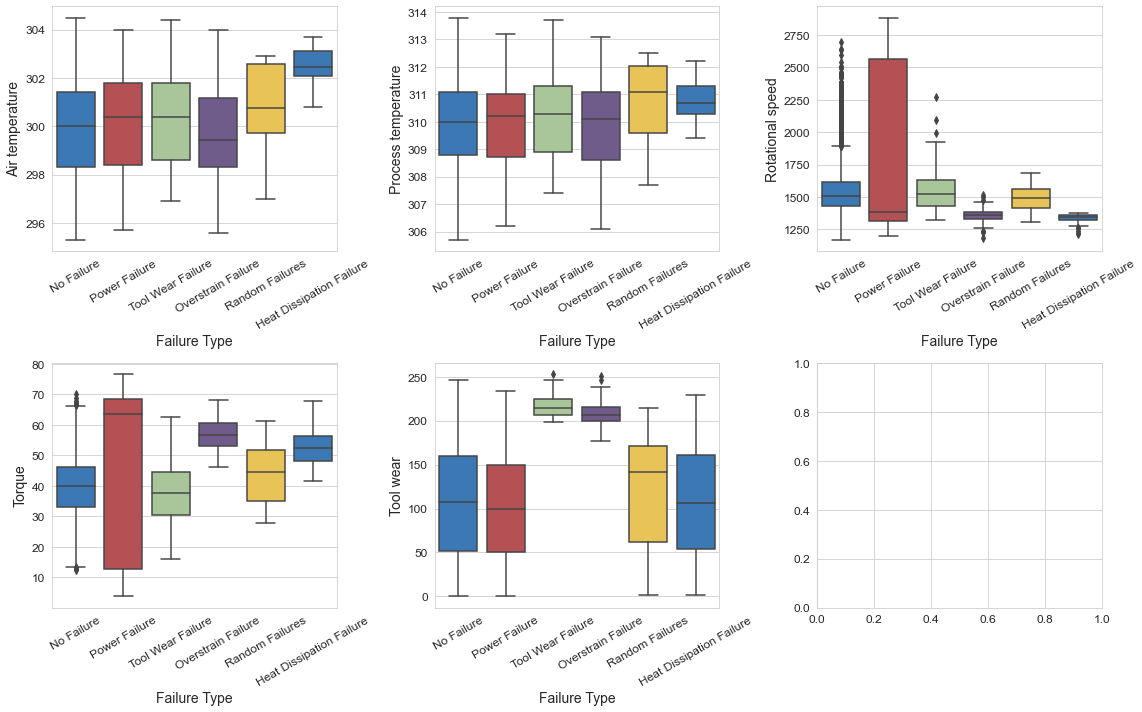

In [4]:
PLT = [CLRS['lblue'],CLRS['lred'], CLRS['lgreen'],CLRS['lpurple'], CLRS['lyellow']]
fig, axs = plt.subplots(2, 3, figsize=[16,10])
axs = axs.flatten()

for i,c in enumerate(NUM_COLS):
    sns.boxplot(data=df, y=c, x=TARGET_COL[1], ax=axs[i], 
                   palette=PLT)
    plt.sca(axs[i])
    plt.xticks(rotation=30)
    
plt.tight_layout()

- It seems that air/process temperature is a primary contributing factor to heat dissipation failure
- It seems that power failure occurs at a wide spectrum of Torque and Rotational speed. Check again below.
- It seems that Tool wear is a major contributing factor to Overstrain Failure and Tool wear failure

### Check which pairs of features separate the data well

In [5]:
NUM_COLS

['Air temperature',
 'Process temperature',
 'Rotational speed',
 'Torque',
 'Tool wear']

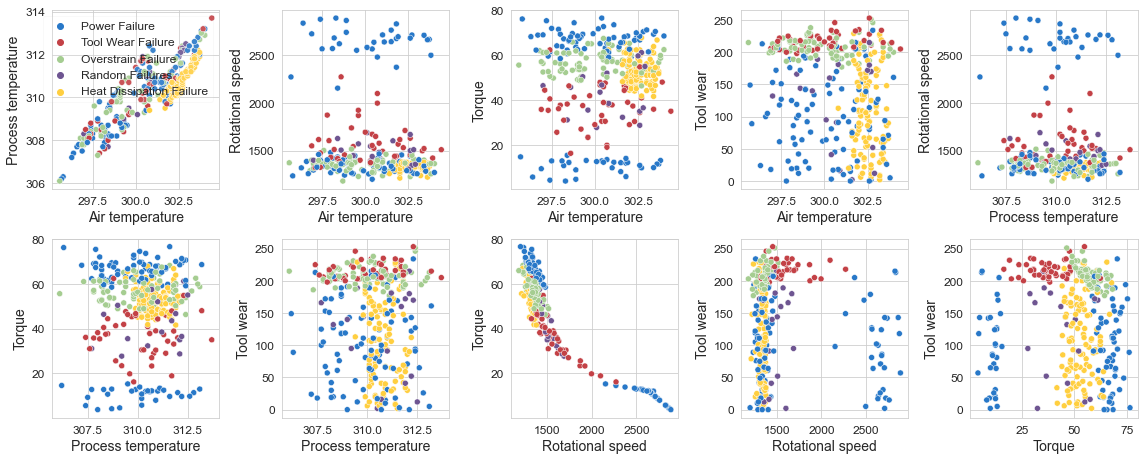

In [6]:
fig, axs = plt.subplots(2, 5, figsize=(16,6.5))
axs = axs.flatten()
for i, c in enumerate(combinations(NUM_COLS, 2)):
    sns.scatterplot(
        data=df[df[TARGET_COL[1]]!='No Failure'], 
        x=c[0], y=c[1], ax=axs[i], hue=TARGET_COL[1], 
        palette=PLT[:5])
    #HOTFIX!
    axs[i].legend(fancybox=True, framealpha=0.1, loc='upper right')
    if i!=0:
        axs[i].get_legend().remove()
        
fig.tight_layout()

- For some failures such as rotational speed and torque, failure occur at extreme values
    - In particular, power failure occurs at these extreme values
- rotational speed and torque combination seems to separate the types of failures well
- It seems that  heat dissipation occurs at lower Torque before Power Failure occurs

TODO:
1. Are there correlated failure type? How to check? Dummyfy first then pearson or point-biserial correlation

# Modeling with `Failure Type` as Outcome Variable

- To simplify, we'll use XGBoost as final model
- Careful for variables not to overwrite binary ones 

In [7]:
import pickle

from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import (precision_score, recall_score, 
    f1_score, log_loss, ConfusionMatrixDisplay,
    classification_report, roc_curve, auc) # --- not used
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import catboost as CB
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance

import shap
from imblearn.combine import SMOTEENN, SMOTETomek

In [8]:
# multiclass classification
lr = LogisticRegression(random_state=0,multi_class='ovr')
svc = SVC(decision_function_shape='ovr')

## Preprocess Data

In [9]:
target_map =dict(zip(
    ['No Failure', 'Power Failure', 'Tool Wear Failure',
        'Overstrain Failure', 'Heat Dissipation Failure'], 
    range(df['Failure Type'].nunique())
       )
    )

df['FType'] = df['Failure Type'].copy()
df['Failure Type'] = df['Failure Type'].replace(target_map)

In [10]:
print(df.shape)
df.head(2)

(10000, 9)


,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Target,Failure Type,FType
UDI,,,,,,,,,
1,M,298.1,308.6,1551,42.8,0,0,0,No Failure
2,L,298.2,308.7,1408,46.3,3,0,0,No Failure


## Final Model

- Skip and just use XGBoost to simplify

### Split Data into Train Set and Test Set
- 80-20 split
- Just change target column

In [11]:
x_train, x_test, y_train, y_test = \
    train_test_split(
        df[NUM_COLS+CAT_COLS], df[TARGET_COL[1]], test_size = 0.2, random_state = 100
                )

y_test[y_test != 0].shape[0] /len(y_test), \
    y_train[y_train != 0].shape[0]/len(y_train)

(0.0355, 0.034625)

### Hyperparameter Tuning

NOTE:
1. For multiclass classification use `average = one of [None, 'micro', 'macro', 'weighted']` to eveluate precision, recall etc

TODO:
1. Reserach which one to use and when
2. For the evaluation, use the classification report from sklearn. Or create custom function to accomodate other eval metrics

# TODO: Follow https://www.kaggle.com/code/gerardocappa/predictive-maintenance-final-project/notebook

TODO
1. Review: What is one vs rest?